## 1. Make classification data and get it ready

In [79]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42) #noise adds randomness
# ramdon seed is set to 42

In [80]:
len(X), len(y)

(1000, 1000)

In [81]:
print(f"First 5 samples of X:\n {X[:5]}") # Has 2 features
print(f"First 5 samples of y:\n {y[:5]}") # Has only one output for every 2 array elements in X
# Y is a Binary classification as the output is either a 0 or a 1

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [82]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [83]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

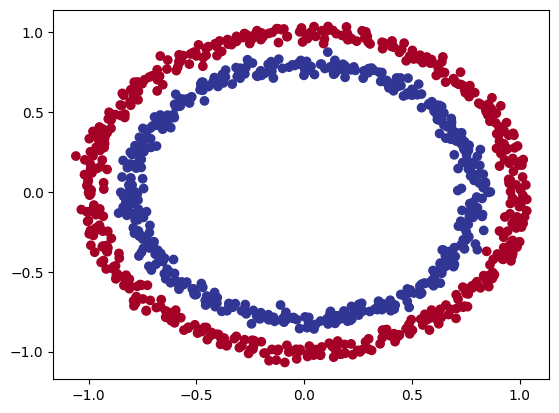

In [84]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

#Given a data point (x[0], x[1]), we decide if it is a blue circle or a red circle

## 1.1 Check input and output shapes


In [85]:
X.shape, y.shape
# 2nd Dimension of X is dependent on the number of feature we have in the input data

((1000, 2), (1000,))

In [86]:
X_sample = X[0]
y_sample = y[0]

X_sample, X_sample.shape, y_sample, y_sample.shape # Y is a scalar

(array([0.75424625, 0.23148074]), (2,), 1, ())

# 1.2 Turn data into tensors and create train and test splits

In [87]:
import torch


In [88]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [89]:
#Split data training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% of data will be test
# random_state is the same for sklearn as manual seed

In [90]:
len(X_train), len(y_test)

(800, 200)

## 2. Building a model (Classify)

i. Device agnostic code

ii. construct a model

iii. define loss function and optimizer

iv. training and test loop

In [91]:
from torch import nn

In [92]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Subclass nn.Module
### 2. nn.Linear for data set layer setup
### 3. forward method for model prediction
### 4. Instantiate a instance of model class and set it to device

In [93]:
# Construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 features from X are extrapolated to 5 features. More features --> More machine learns --> Better the model
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # output layer has same no. of features as y

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

model_0 = CircleModelV0()
model_0.to(device)

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [94]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [95]:
# Replicate the above using sequential
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [96]:
# Make predictions
model_0.state_dict()
# layer 1 : weight - 2 * 5, bias - 5
# layer 2 : weight - 5 * 1, bias - 1
# layer x : weight - out * in, bias - out

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [97]:
# Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss function

Ex:
regression : MAE or MSE
classification: Binary cross entropy, multi-class entropy

optimizer:
SGD and Adam

In [98]:
# loss fucntions
loss_fn = nn.BCEWithLogitsLoss() # BCE with sigmoid activation fucntnion built in
# nn.BCELoss() needs to have inputs which have gone through the sigmoid activation function prior to input to BCELoss

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [99]:
# Calculate accuracy - correct prediction out of 100 test samples
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

0. Train mode
1. forward pass
2. loss calc
3. optimizer grad
4. backward propagation
5. optimizer step

### 3.1 From raw -> logits ->predictions -> prediction labels

Model output are ---> **logits**

We convert the logits ---> prediction probabilites by passing them through *activation functions*:

Binary classifciation : sigmoid activation fucntion

Multi class classification : softmax activation function

Prediction probabilities --> Prediction labels

In [100]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_train.to(device))[:5]
y_logits [:5], y_train [:5]

(tensor([[ 0.2826],
         [ 0.3236],
         [ 0.0202],
         [ 0.0421],
         [-0.0271]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.]))

In [101]:
# Use sigmoid activation function on model output for prediction probabilities
y_pred_prbs = torch.sigmoid(y_logits)
y_pred_prbs

tensor([[0.5702],
        [0.5802],
        [0.5051],
        [0.5105],
        [0.4932]], device='cuda:0')

In [102]:
torch.round(y_pred_prbs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [103]:
y_preds = torch.round(torch.sigmoid(model_0(X_train.to(device))[:5])) # logits -> pred probs -> pred lables
y_preds, y_preds.squeeze()

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>))

## 3.2 Training and test loop

In [104]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
y_train = y_train.to(device)

# Training loop
for epoch in range(epochs):
  # 0. Evaluation mode
  model_0.train()

  # 1. Forward pass:  Seperate logis and predictions
  y_logit = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))

  # 2. Loss calculation/ Accuracy
  loss = loss_fn(y_logit, y_train) # BCEwithLogitLoss expects raw logits;
  #loss = loss_fn(torch.sigmoid(y_train), y_train) # BCELoss expects prediction probabilites as inputs
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero gradients
  optimizer.zero_grad()

  # 4. backward propagation
  loss.backward()

  # 5. Update optimizer
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logit = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logit))

    # 2. Calculation of loss and acuration
    test_loss = loss_fn(test_logit, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  print(f"Epoch: {epoch} | Training loss: {loss:.5f}, Acc: {acc:.2f}| Test loss: {test_loss:.5f}, Acc: {test_acc:.2f}")

Epoch: 0 | Training loss: 0.69796, Acc: 51.88| Test loss: 0.69440, Acc: 58.00
Epoch: 1 | Training loss: 0.69767, Acc: 51.88| Test loss: 0.69420, Acc: 57.50
Epoch: 2 | Training loss: 0.69741, Acc: 52.00| Test loss: 0.69401, Acc: 56.50
Epoch: 3 | Training loss: 0.69716, Acc: 52.00| Test loss: 0.69385, Acc: 56.50
Epoch: 4 | Training loss: 0.69694, Acc: 51.50| Test loss: 0.69370, Acc: 56.00
Epoch: 5 | Training loss: 0.69673, Acc: 51.25| Test loss: 0.69356, Acc: 56.00
Epoch: 6 | Training loss: 0.69654, Acc: 51.38| Test loss: 0.69344, Acc: 56.50
Epoch: 7 | Training loss: 0.69636, Acc: 51.25| Test loss: 0.69333, Acc: 56.50
Epoch: 8 | Training loss: 0.69619, Acc: 51.38| Test loss: 0.69323, Acc: 55.00
Epoch: 9 | Training loss: 0.69604, Acc: 51.25| Test loss: 0.69314, Acc: 54.00
Epoch: 10 | Training loss: 0.69590, Acc: 51.25| Test loss: 0.69305, Acc: 53.00
Epoch: 11 | Training loss: 0.69577, Acc: 51.12| Test loss: 0.69298, Acc: 52.00
Epoch: 12 | Training loss: 0.69564, Acc: 51.12| Test loss: 0.6

## 4. Make predictions and evaluate the model

From metrics the model is not learning much

Let us make predictions and make it visual

In [105]:
import requests
from pathlib import Path

# Download helper functions from Pytorch repo
if Path("helper_functions.py").is_file():
  print("functions alr exist")
else:
  print("Downloading assets")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f: # Create a file with given name, enable writing access, file object is called "f"
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

functions alr exist


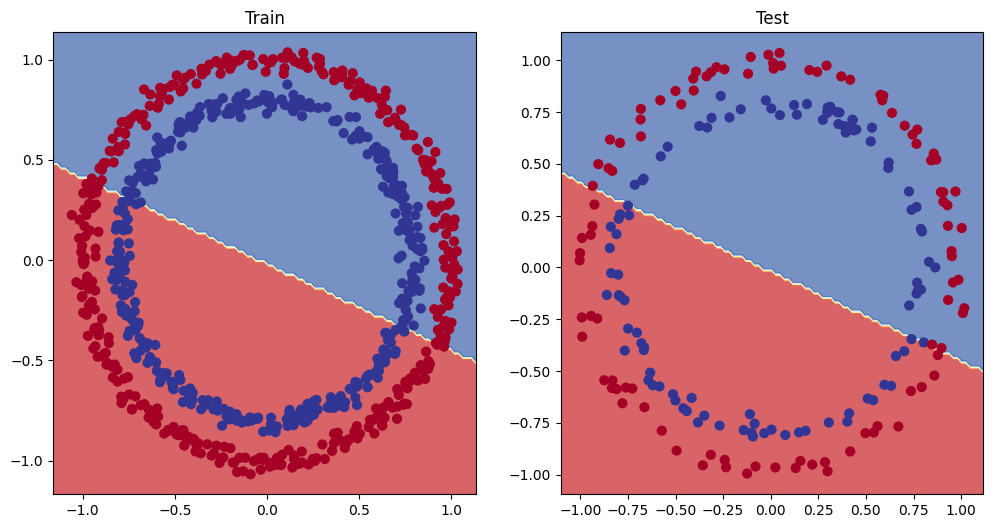

In [106]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## The layers we used to build the model are linear. The data is circular.

As seen above the model is trying to draw a line across the points to enable predictions.

We need a circle to be drawn instead

## 5. Imporving a model (from model perspective)
### Alter the hyperparameters (set by coder)
* Add more layers - give model more chances to learn the features
* Add more hidden units - from 5 to 10 units (more parameters -> More learning)
* Fit for more epochs
* Changing the activation functions **within THE MODEL**
* Change the learning rate
* Change the loss function

We can improve the model using changes in data too!

In [107]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    # return self.layer_3(self.layer_2(self.layer_1(x))) same as the above
    return z

model_1 = CircleModelV1()
model_1.state_dict()
model_1.to(device
           )

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [108]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)



In [109]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):
  model_1.train()

  #1. Forward pass
  y_logits = model_1(X_train)
  y_preds = torch.round(torch.sigmoid(y_logits))

  #2. Loss and accuracy
  loss = loss_fn(y_logits.squeeze(), y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  #3. Optimer zero grad
  optimizer.zero_grad()

  #4. Back propagation
  loss.backward()

  #5. Optimizer step
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    #1. predict
    test_logits = model_1(X_test)
    test_preds = torch.round(torch.sigmoid(test_logits))

    #2. # loss and accuracy
    test_loss = loss_fn(test_logits.squeeze(), y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss}, Accuracy: {acc} | Test Loss: {test_loss}, Accuracy {test_acc}")

Epoch: 0 | Train Loss: 0.6939550638198853, Accuracy: 40000.0 | Test Loss: 0.6926146745681763, Accuracy 45.0
Epoch: 100 | Train Loss: 0.6930478811264038, Accuracy: 40000.0 | Test Loss: 0.6937904357910156, Accuracy 45.0
Epoch: 200 | Train Loss: 0.6929860711097717, Accuracy: 40000.0 | Test Loss: 0.6943727135658264, Accuracy 45.0
Epoch: 300 | Train Loss: 0.6929804682731628, Accuracy: 40000.0 | Test Loss: 0.6945767998695374, Accuracy 45.0
Epoch: 400 | Train Loss: 0.6929799318313599, Accuracy: 40000.0 | Test Loss: 0.6946452260017395, Accuracy 45.0
Epoch: 500 | Train Loss: 0.6929798722267151, Accuracy: 40000.0 | Test Loss: 0.6946680545806885, Accuracy 45.0
Epoch: 600 | Train Loss: 0.6929798722267151, Accuracy: 40000.0 | Test Loss: 0.6946756839752197, Accuracy 45.0
Epoch: 700 | Train Loss: 0.6929798722267151, Accuracy: 40000.0 | Test Loss: 0.6946782469749451, Accuracy 45.0
Epoch: 800 | Train Loss: 0.6929798722267151, Accuracy: 40000.0 | Test Loss: 0.6946790814399719, Accuracy 45.0
Epoch: 900 |

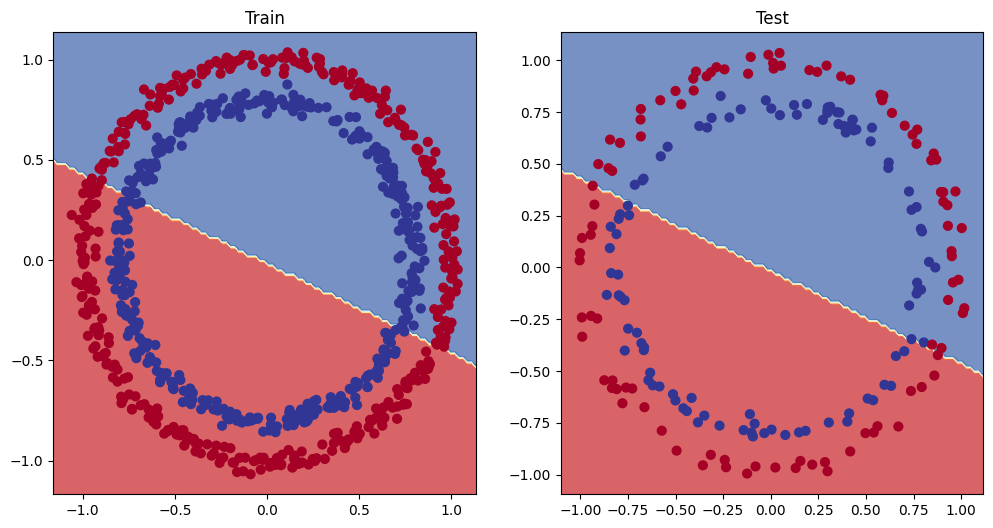

In [110]:
#plot the decision boundary
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Prepare a linear regression data set so that we can check if the model is broken or the method we use to learn is broken

We just reuse the same kind of data set from before

In [111]:
# Create data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#create data
X_regression = torch.arange(start=start, end=end, step=step, device=device).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

len(y_regression)

100

In [112]:
train_split = int(0.8 * len(X_regression))

X_regression_train, X_regression_test, = X_regression[:train_split], X_regression[train_split:]

y_regression_train, y_regression_test = y_regression[:train_split], y_regression[train_split:]

In [113]:
len(y_regression_test), len(X_regression_train), len(y_regression_train), len(y_regression_test)

(20, 80, 80, 20)

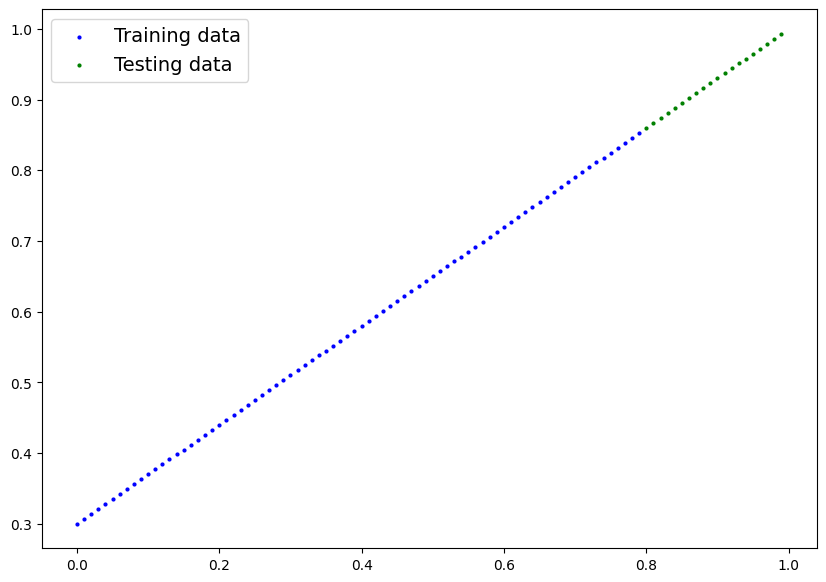

In [114]:
plot_predictions(train_data=X_regression_train.cpu().numpy(),
                 train_labels=y_regression_train.cpu().numpy(),
                 test_data=X_regression_test.cpu().numpy(),
                 test_labels=y_regression_test.cpu().numpy())

In [115]:
X_regression_train[:10]

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]], device='cuda:0')

In [116]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [117]:
# Need to change the number of input and output features

model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

In [118]:
model_2.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [119]:
#Loss function
loss_regression_fn = nn.L1Loss()

#optimizer
optimizer_regression = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [120]:
# Train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  #Train mode
  model_2.train()

  #1. Forward pass
  y_regression_preds=model_2(X_regression_train)

  #2.Loss calculation
  loss_regression = loss_regression_fn(y_regression_preds, y_regression_train)

  #3. Zero grad
  optimizer_regression.zero_grad()

  #4. back propagations
  loss_regression.backward()

  #5. optimizer step
  optimizer_regression.step()

  # Model evaluaions
  model_2.eval()
  with torch.inference_mode():
    #1. forward propagation
    test_regression_preds = model_2(X_regression_test)

    #2. Loss calculation
    test_regression_loss = loss_regression_fn(test_regression_preds ,y_regression_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss_regression} | Test Loss: {test_regression_loss}")

Epoch: 0 | Train Loss: 0.7598585486412048 | Test Loss: 0.9110288619995117
Epoch: 10 | Train Loss: 0.4024040400981903 | Test Loss: 0.5047394633293152
Epoch: 20 | Train Loss: 0.06007448956370354 | Test Loss: 0.10150804370641708
Epoch: 30 | Train Loss: 0.015594908967614174 | Test Loss: 0.03230736032128334
Epoch: 40 | Train Loss: 0.030917156487703323 | Test Loss: 0.0011067151790484786
Epoch: 50 | Train Loss: 0.03196068853139877 | Test Loss: 0.001076257205568254
Epoch: 60 | Train Loss: 0.03191908076405525 | Test Loss: 0.0017019034130498767
Epoch: 70 | Train Loss: 0.030806494876742363 | Test Loss: 0.0009658545604906976
Epoch: 80 | Train Loss: 0.030771717429161072 | Test Loss: 0.001497569726780057
Epoch: 90 | Train Loss: 0.029671872034668922 | Test Loss: 0.0009232998127117753
Epoch: 100 | Train Loss: 0.028579531237483025 | Test Loss: 0.0008127004257403314
Epoch: 110 | Train Loss: 0.029621517285704613 | Test Loss: 0.0019708783365786076
Epoch: 120 | Train Loss: 0.027476413175463676 | Test Loss:

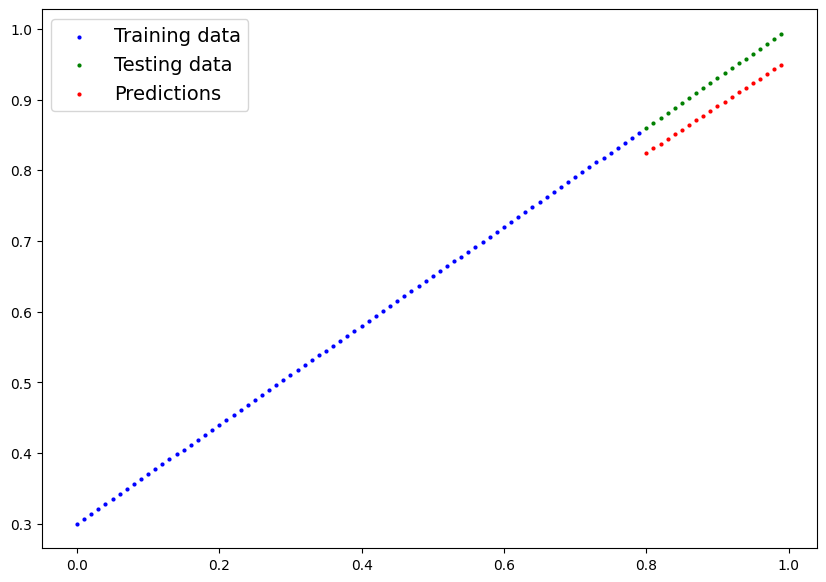

In [121]:
plot_predictions(train_data=X_regression_train.cpu().numpy(),
                 train_labels=y_regression_train.cpu().numpy(),
                 test_data=X_regression_test.cpu().numpy(),
                 test_labels=y_regression_test.cpu().numpy(),
                 predictions=test_regression_preds.cpu().numpy())

## 6. The mission piece is non-linearly

All patterns can be drawn with infinite linear and non-linear lines (linear and non-linear functions)

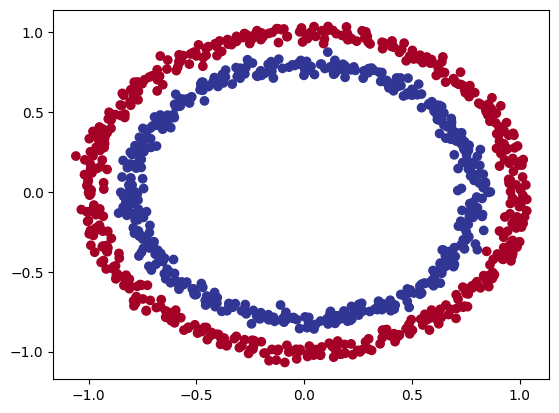

In [122]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [123]:
# Convert data to tensors
import torch
from sklearn.model_selection import train_test_split

#turn data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

### 6.2 Building a Non-linear activation functions
* Linear = staright lines
* Non - Linear = non straight lines

In [124]:
#Bulding a model with non linearity
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [125]:
#Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(lr=0.1, params=model_3.parameters())

### 6.3 Training a model with non-linearity

In [126]:
model_3.to(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [127]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all the data on same device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 100 == 0:
    print(f"Epochs: {epoch} | Training Loss: {loss} Accuracy: {acc} | Test Loss: {test_loss} Accuracy: {test_acc}")

Epochs: 0 | Training Loss: 0.6929463148117065 Accuracy: 51.37500000000001 | Test Loss: 0.6931881308555603 Accuracy: 50.0
Epochs: 100 | Training Loss: 0.691152811050415 Accuracy: 51.37500000000001 | Test Loss: 0.6910240054130554 Accuracy: 52.5
Epochs: 200 | Training Loss: 0.6897744536399841 Accuracy: 51.37500000000001 | Test Loss: 0.6893961429595947 Accuracy: 55.00000000000001
Epochs: 300 | Training Loss: 0.6879494190216064 Accuracy: 51.37500000000001 | Test Loss: 0.6872316002845764 Accuracy: 56.00000000000001
Epochs: 400 | Training Loss: 0.6851678490638733 Accuracy: 51.37500000000001 | Test Loss: 0.6841148734092712 Accuracy: 56.49999999999999
Epochs: 500 | Training Loss: 0.6810224652290344 Accuracy: 51.37500000000001 | Test Loss: 0.6794120073318481 Accuracy: 56.49999999999999
Epochs: 600 | Training Loss: 0.675148606300354 Accuracy: 51.37500000000001 | Test Loss: 0.6728507876396179 Accuracy: 56.00000000000001
Epochs: 700 | Training Loss: 0.6665886640548706 Accuracy: 51.37500000000001 | 

### 6.4 Evaluate model which has non-linear activation functions

In [128]:
test_preds[:10], y_test[:10
                        ]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

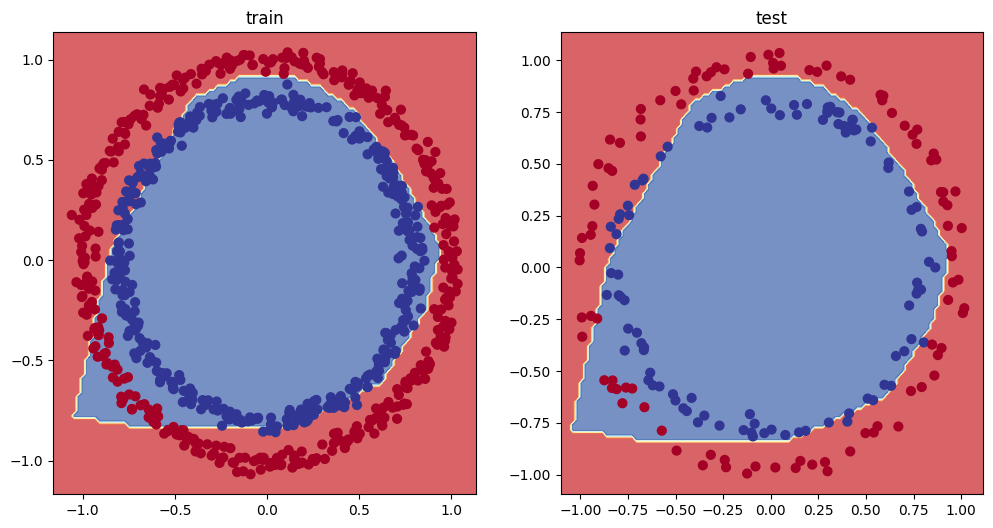

In [129]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

## 7 Replicating non-linear activation functions

Using a combination of linear and non linear functions

In [130]:
#Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [131]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

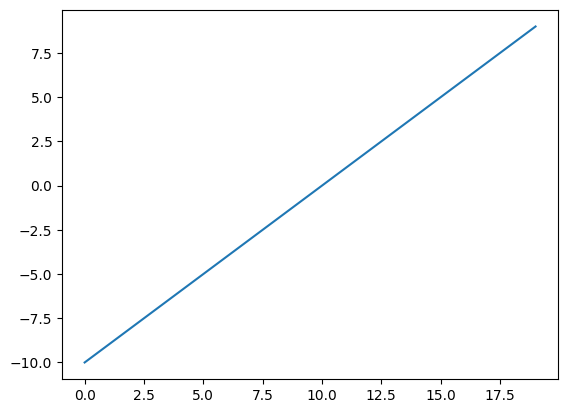

In [132]:
# Visualize
plt.plot(A)

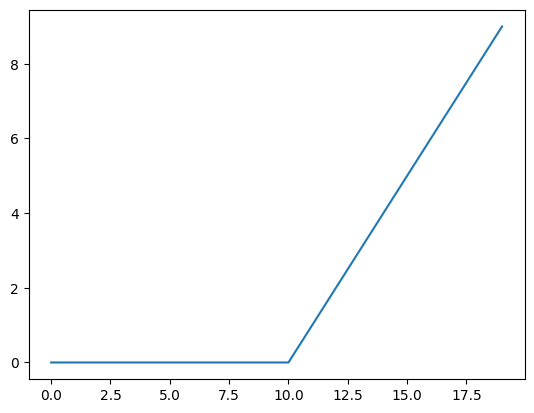

In [133]:
plt.plot(torch.relu(A))

In [134]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # Negative input -> 0, Positive input returned as such

In [135]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

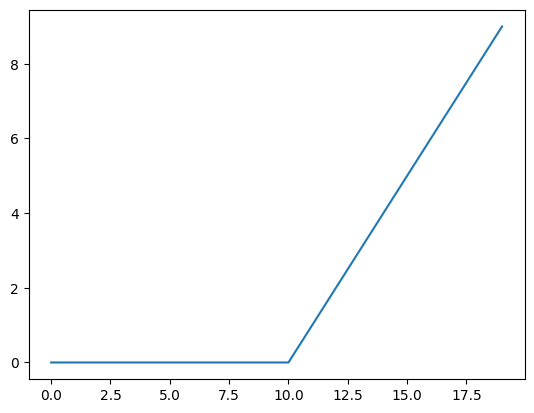

In [136]:
plt.plot(relu(A))

In [137]:
# we will do the same for Sigmoid
def sigmoid(x:torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

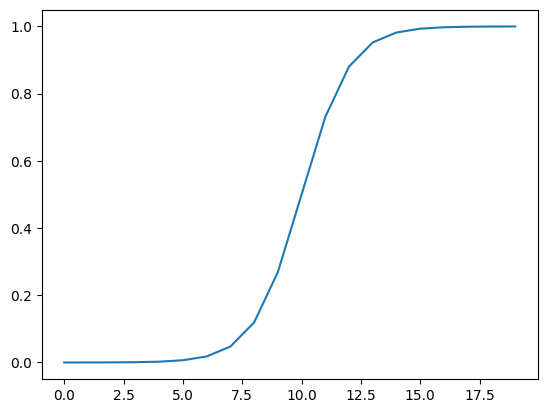

In [138]:
plt.plot(sigmoid(A))

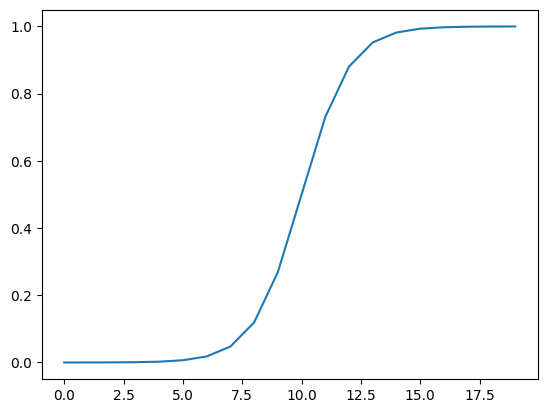

In [139]:
plt.plot(torch.sigmoid(A))

 ## 8. Putting it all together with a multi-class classification problem

 * Binary classification: The labels are only of 2 types
 * Multi-class classification: Labels have more than 2 types

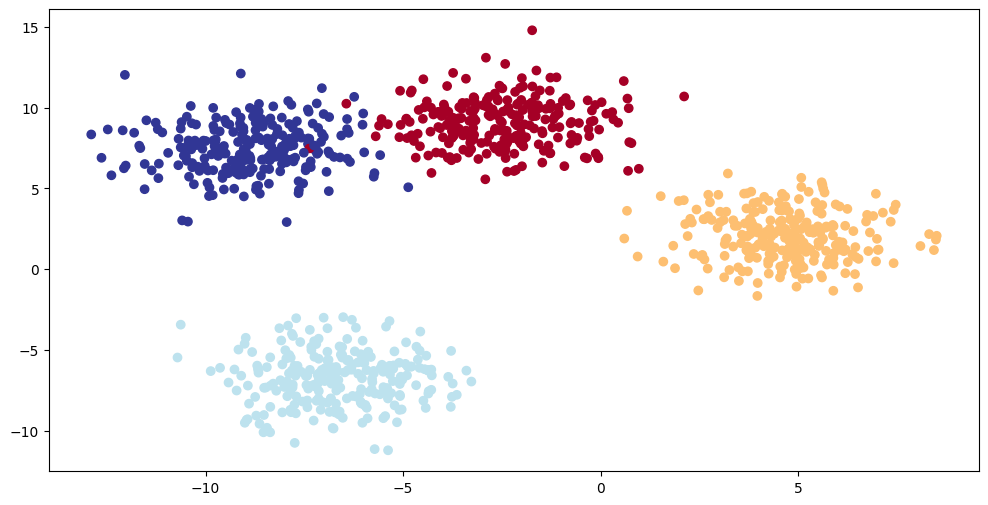

In [168]:
### 8.1 import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set parameters
NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_SEED = 42

# 1. Create dataset
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # This standard deviation gives the clusters some innate randomness
                            # if cluster = 0, that means that all the dots of one color will be placed within on point, making it not reality
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # The class labels have to of type int, not with floating point values

# 3. Split data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(12, 6))
plt.scatter(x=X_blob[:, 0], y=X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

 ### 8.2 Bulding a multi-class classification model

In [169]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [184]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Multi-class classification model

    Args:
    input_features (int): Number of input features
    output_features (int): Number of output classes
    hidden_units (int): Hidden units between layers, default 8

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

# Create a instance and set to device
model_4 = BlobModel(input_features=2, # Each data point has x and y coordinate
                    output_features=4) # There are total 4 classes
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [185]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

In [186]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

### 8.3 optimizer and loss function for multi-class classificaiton

In [187]:
# Loss function
loss_fn = nn.CrossEntropyLoss() # Apply weights if we have a unbalanced samples

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Gettind predition probabilits for multi-class classification

Model ouput = logits -> prediction probablities -> predction labels

In [188]:
X_blob_train = X_blob_train.to(device)

In [189]:
model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('linear_layer_stack.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0

In [190]:
y_blob_pred = model_4(X_blob_train).to(device)[:5]
y_blob_pred

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [191]:
# Covert logits to predictions probabilites
y_pred_probs = torch.softmax(y_blob_pred, dim=1)
y_pred_probs

tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [192]:
torch.sum(y_pred_probs[1])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [193]:
torch.argmax(y_pred_probs)

tensor(7, device='cuda:0')

In [194]:
torch.argmax(y_pred_probs, dim=1)

tensor([1, 3, 2, 2, 3], device='cuda:0')

### 8.5 Build a training and testing loop

In [195]:
y_logits[:10], y_blob_train[:10]

(tensor([ 0.2165, -0.4163, -0.1776, -0.0779,  0.2054,  0.1353,  0.1392,  0.1694,
         -0.2816, -0.7396], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0'))

In [196]:
# Fit the multi-class model to data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Device agnostic code
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Set number of epochs
epoch = 1000

for epoch in range(epochs):

  #Model in training mode
  model_4.train()

  #1. Predictied logits
  y_blob_logits = model_4(X_blob_train)
  y_blob_pred_probs = torch.softmax(y_blob_logits, dim=1)
  y_blob_preds = torch.argmax(y_blob_pred_probs, dim=1)

  #2. loss and accuracy
  loss = loss_fn(y_blob_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_blob_preds)

  #3. optimizer zero gradients
  optimizer.zero_grad()

  #4. backward propagation
  loss.backward()

  #5. Step optimizer
  optimizer.step()

  #Evaluation
  model_4.eval()

  #Predictions
  with torch.inference_mode():
    #1. prediction
    test_blob_logits = model_4(X_blob_test)
    test_blob_pred_prob = torch.softmax(test_blob_logits, dim=1)
    test_preds = torch.argmax(test_blob_pred_prob, dim=1)

    #2. Loss and accuracy
    test_loss = loss_fn(test_blob_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss {loss}, Train accuracy: {acc} | Test loss {test_loss}, Test accuracy: {test_acc}")

Epoch: 0 | Train loss 1.0432369709014893, Train accuracy: 65.5 | Test loss 0.5786145925521851, Test accuracy: 95.5
Epoch: 100 | Train loss 0.031848691403865814, Train accuracy: 99.125 | Test loss 0.022926397621631622, Test accuracy: 99.5
Epoch: 200 | Train loss 0.027066199108958244, Train accuracy: 99.125 | Test loss 0.017038244754076004, Test accuracy: 99.5
Epoch: 300 | Train loss 0.025644633919000626, Train accuracy: 99.25 | Test loss 0.014989936724305153, Test accuracy: 99.5
Epoch: 400 | Train loss 0.024923061951994896, Train accuracy: 99.25 | Test loss 0.013892702758312225, Test accuracy: 99.5
Epoch: 500 | Train loss 0.02444371208548546, Train accuracy: 99.25 | Test loss 0.013177362270653248, Test accuracy: 99.5
Epoch: 600 | Train loss 0.02407453954219818, Train accuracy: 99.25 | Test loss 0.012653779238462448, Test accuracy: 99.5
Epoch: 700 | Train loss 0.023765580728650093, Train accuracy: 99.25 | Test loss 0.012240217998623848, Test accuracy: 99.5
Epoch: 800 | Train loss 0.02349

### 8.6 Making evaluation and predictions

#### Use Non-linear model for graph

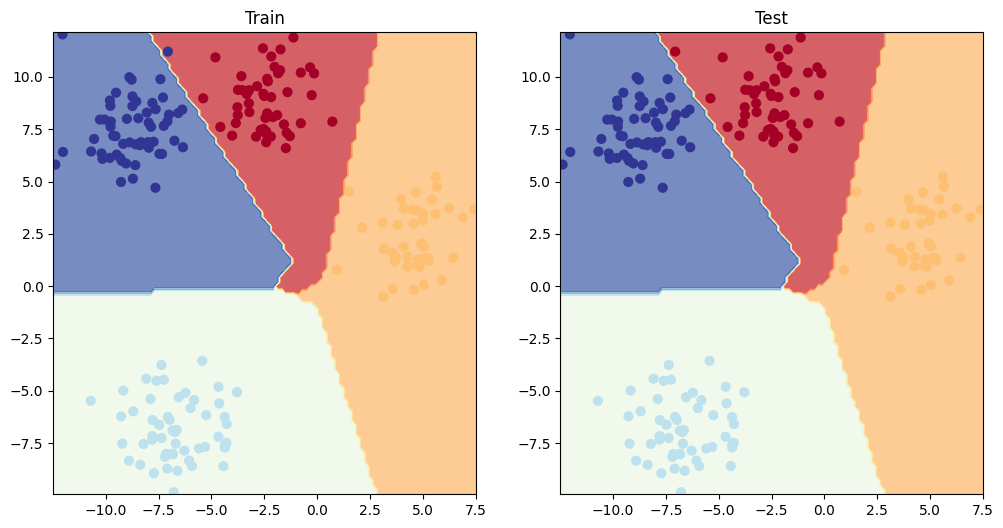

In [183]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, test_preds)

 #### Use linear graph for predictions

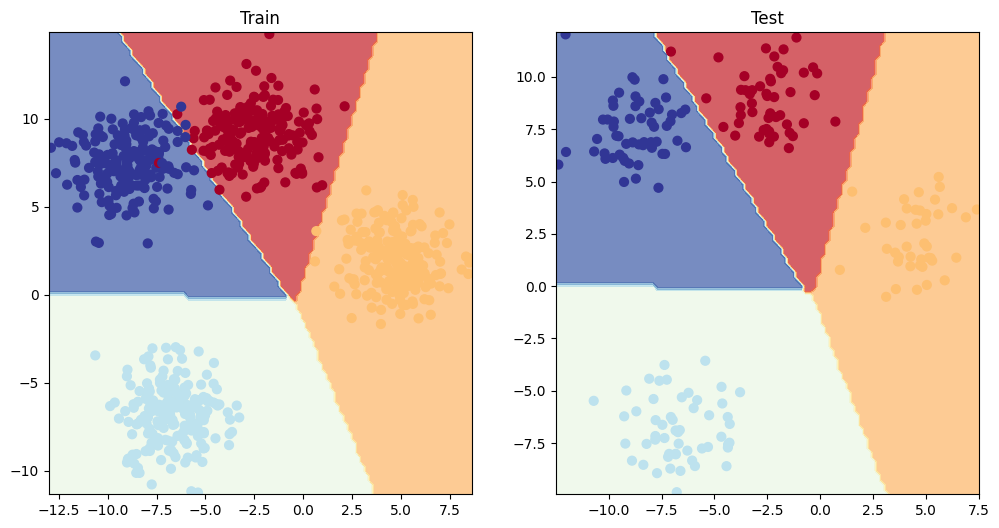

In [198]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, test_preds)

As seen the data set can have a successful prediction with a linear and a non linear model as the data points are not seperated by a circular perimeter

## 9. More valuation metrics for classification models

* Accuracy - out of 100 samples, how many is predicted right
* Precision
* Recall
* F1-score
* Confusion matrix
* Classicification report

In [199]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [202]:
from torchmetrics import Accuracy

#Set up metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# accuracy calculation
torchmetric_accuracy(test_preds, y_blob_test)

tensor(0.9950, device='cuda:0')